### Natasha-Suchi team.


### Imports

In [1]:
import pandas as pd
import nltk, re, string
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn import svm
from nltk.corpus import stopwords

from sklearn import linear_model
from sklearn.naive_bayes import MultinomialNB


from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics
import itertools
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.ensemble import VotingClassifier


### Preprocess Data

Read the csv file and make a dataframe.
- For training: Randomize and Divide it into 80:20 partitions
- For Testing: Use the whole dataframe for training and test on the provided unlabeled csv

In [2]:
# Reads the csv file and load into dataframe and divides it into training and test set
def read_data(run_type):
    df = pd.read_csv("yelp_data_official_training.csv", sep = "|", )
    df = df[df["Review Text"].notnull()]
    if run_type == "train":
        df.apply(np.random.permutation)
        df_train = df[:round(0.8*len(df))]
        df_test = df[round(0.8*len(df)):]
    else:
        df_train = df
        df_test = pd.read_csv("yelp_data_official_test_nocategories.csv", sep="|")
    return df_train, df_test

### Tokenization

This function takes a text and does the following to return the tokens:
* Use nltk word_tokenize to create tokens
* Use wordNetLemmatizer for lemmatization
* Use porterStemmer to stem the resulting tokens
* Remove stopwords, punctuations and tokens of size less than 2

Things we tried that didn't work:
* Suchi tried a regular expression tokenizer but did not get a better result and since it was slower we did not use it in the final code
* Natasha tried different techniques to alter the stopwords. Her idea was to add some dogs and cats into stopwords in order to eliminate some confusion between "Veterinarians" and "Pets" categories, but it didn't work very well. 
* Another idea was to take in only nouns (NN and NNS) to reduce "noise" (i.e. adjectives and other words shared by all reviews). It did not change the accuracy. 
* One more approach was too "innovative": take hypernyms instead of actual tokens and make them tokens. Hypothesis was that on the hyper-level the lexical content of the reviews would be more distinguishable. Turned out, on the hyper-level it is pretty random-looking.

In [3]:
def build_tokens(text):
    tokens = nltk.tokenize.word_tokenize(text)
    tokens = [nltk.WordNetLemmatizer().lemmatize(token) for token in tokens]
    tokens= [nltk.PorterStemmer().stem(token) for token in tokens]
    tokens = [token for token in tokens if len(token)>2 and token not in stopwords.words('english') and token not in string.punctuation]
    return tokens


# def build_tokens(text):
#     pattern= r'''(?x) (?:[A-Z]\.)+|(?:\w+(?:[-']\w+)*)|(?:\$?\d+(?:\.\d+)?%?)+|(?:\.\.\.)'''
#     tokens = (nltk.regexp_tokenize(text,pattern))
#     tokens = [token.lower() for token in tokens if token not in stopwords.words('english') and len(token)>2]
#     tokens = [nltk.WordNetLemmatizer().lemmatize(token) for token in tokens]
#     tokens= [nltk.PorterStemmer().stem(token) for token in tokens]
#     return tokens

### Feature Extraction

For feature extraction tfidf vectorizer was used 
* We used upto trigram
* max_df was set to 0.5 which excluded tokens that occured more than half of the reviews
* min_df was set to 10 that excluded tokens that occured in less than 10 reviews
* Maximum number of features was capped at 4000

After getting 4000 feaures, we decided to do feature selection using:
* chi-square - selected top 2000 features

We tried increasing max_features. Though it performed well on the validation set, The final accuracy on the test data was lower



In [4]:
# tfidf feature extraction and chi2 selection
def feature_extraction(df_train, df_test):
    vectorizer = TfidfVectorizer(sublinear_tf=True, ngram_range=(1,3), max_df= 0.5, analyzer= "word", tokenizer= build_tokens ,min_df=10,max_features=4000) #current best for max_features = 4000
    
#     count_vectorizer = CountVectorizer(analyzer="word", tokenizer=build_tokens, ngram_range=(1,3), max_features=1000)
    
    X_train = vectorizer.fit_transform(df_train["Review Text"]).todense()
    X_test = vectorizer.transform(df_test["Review Text"]).todense()

    ch2 = SelectKBest(chi2, k = 2000) #current best for k=2300(0.8815625)
    X_train = ch2.fit_transform(X_train, df_train.Category)
    X_test = ch2.transform(X_test)
    
    ####### Debug run #######
    # feature_names = vectorizer.get_feature_names()
    # feature_names = [feature_names[i] for i in ch2.get_support(indices=True)]
    
    return X_train, X_test

### Classifier

##### We tried different Classifiers and tried to find the optimal parameters set

** We also tried to actually ensemble different classifiers, and it worked well and gave us a higher accuracy compared to any of the classifiers tested independently. But it was taking a very long time to run.**

*More discussions on Ensembles and what did not work in this is discussed in a separate section titled Ensemble.*

In [5]:
# 
def classify_train(clf_type, X_train, train_category):
    if clf_type == "logreg":
#         logreg = linear_model.LogisticRegression(tol=1e-8, penalty='l2', C=4, max_iter=1000)
        logreg = linear_model.LogisticRegression(C=8.25, max_iter=3000, tol=1e-8)
        logreg.fit(X_train, train_category)
        return logreg
    elif clf_type == "svm_rbf":
        clf = svm.SVC(kernel='rbf', gamma=0.8, C=1, decision_function_shape="ovr", probability=True)
        clf.fit(X_train, train_category)
        return clf
    elif clf_type == "svm_linear":
        clf = svm.SVC(kernel = 'linear', probability = True)
        clf.fit(X_train, train_category)
        return clf
    elif clf_type == "sgd":
        clf = linear_model.SGDClassifier(n_iter=2000,loss = 'modified_huber', penalty = 'elasticnet', n_jobs=-1)
        clf.fit(X_train,train_category)
        return clf
    elif clf_type == "nb":
        clf = MultinomialNB()
        clf.fit(X_train,train_category)
        return clf
    # ensemble of different classifiers. We used a soft voting measure to combine the output
    elif clf_type == "ensemble":
        clf1 = linear_model.LogisticRegression(C=8.25, max_iter=3000, tol=1e-8)
        clf3 = svm.SVC(kernel='rbf', gamma=0.8, C=1, decision_function_shape="ovr",probability=True)
        clf4 = linear_model.SGDClassifier(n_iter=2000,loss = 'modified_huber', penalty = 'elasticnet', n_jobs=-1)
        eclf = VotingClassifier(estimators=[('lr',clf1), ('svm_rbf',clf3), ('sgd' , clf4)], voting="soft")
        eclf = eclf.fit(X_train,df_train.Category)
        return eclf

##### This function takes a trained classifier and a set of features as input and returns the prediction of the classifier

In [6]:

def classify_predict(clf, X_test):
    predictions = clf.predict(X_test)
    return predictions

def check_val_score(predictions, true_vals):
    return metrics.accuracy_score(true_vals,predictions)

##### This function takes a set of labels and prepares the output csv file

In [7]:

def write_output(predictions):
    output = pd.DataFrame(predictions)
    output.columns = ["Category"]
    output.index.names = ["Id"]
    output.to_csv(path_or_buf="submission.csv", sep=",")

## Training Run

* Calls read_data with "train" and gets the training and validation split
* Calls feature_extraction and gets the features for training and validation
* Instantiates a classifier and trains it on train data. (Available classifiers- logreg, svm_rbf, svm_linear, nb and sgd)
* Calls classify predict and gets the predicted labels on validation data
* check_val_score: Finds the accuracy score and prints it as output

In [8]:
# Training Run 
df_train, df_test = read_data("train")
X_train, X_test = feature_extraction(df_train, df_test)

In [9]:
clf = classify_train("logreg", X_train, df_train.Category)

predictions = classify_predict(clf, X_test)
print(check_val_score(predictions, df_test.Category))

0.878229166667


In [18]:
#Training run with ensemble
clf = classify_train("ensemble", X_train, df_train.Category)

predictions = classify_predict(clf, X_test)
print(check_val_score(predictions, df_test.Category))

0.879895833333


## Test Run

* Calls read_data with "test" and gets the training and testing data
* calls feature_extraction and gets the features for training and testing
* Instantiates a classifier and trains it on train data. (Available classifiers- logreg, svm_rbf, svm_linear, nb and sgd)
* calls classify predict and gets the predicted labels on test data
* Write_output: Prepares the output csv

In [ ]:
# Test Run    
df_train, df_test = read_data("test")
X_train,X_test = feature_extraction(df_train, df_test)

In [ ]:
clf = classify_train("logreg", X_train, df_train.Category)
predictions = classify_predict(clf, X_test)
write_output(predictions)

In [ ]:
#Test run with ensemble
clf = classify_train("ensemble", X_train, df_train.Category)

predictions = classify_predict(clf, X_test)
write_output(predictions)

## Ensemble

**One option (a simpler one) was to try bagging (bootstrap aggregation). But it returned an accuracy lower than just logreg did** 

In [ ]:
from sklearn.ensemble import BaggingClassifier
bagging = BaggingClassifier(linear_model.LogisticRegression(), n_estimators=10, max_samples=1.0, max_features=1.0, warm_start=True)
bagging = bagging.fit(X_train,df_train.Category)
predictions = bagging.predict(X_test)
print(check_val_score(predictions, df_test.Category))

## Confusion Matrix

** In this section we generate a confusion matrix for our validation set. **

In [10]:
cnf_matrix =confusion_matrix(df_test.Category,predictions)

In [11]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

** The plot gives us a visual representation of how well our algorithm performs in predicting different labels. **
* We can see that there were fewer examples for Veterinarians and Pets. In order to handle this class imbalance, we tried passing the class weights in our classifiers. But, it did not give a better performance.
* We can also see that our algorithm performs reasonably well for the first five classes. But, it fails to disambiguate between pets and veterinarians properly.

Confusion matrix, without normalization
[[3081   42  172   85    4    5]
 [  37 1083   33  174    0    6]
 [  34   25 2109   37    4    1]
 [  54  168   80 1230    2    2]
 [   3    5   55    4  765   17]
 [   6   15    3   13   83  163]]


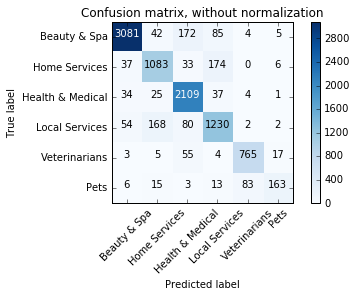

In [12]:
plot_confusion_matrix(cnf_matrix, classes=["Beauty & Spa", "Home Services", "Health & Medical", "Local Services", "Veterinarians", "Pets"], title='Confusion matrix, without normalization')

**This function computes per category precision, recall and f1 score (to show how many reviews were categorised correctly and incorrectly) as well as the confusion matrix**

In [17]:
def benchmark(X_train, y_train, X_test, y_test, name):
    # print("parameters:", params)
    t0 = time()
    clf = classify_train("logreg", X_train, df_train.Category)
    print("done in %fs" % (time() - t0))

    if hasattr(clf, 'coef_'):
        print("Percentage of non zeros coef: %f"
              % (np.mean(clf.coef_ != 0) * 100))
    print("Predicting the outcomes of the testing set")
    t0 = time()
    pred = clf.predict(X_test) #predictions
    print("done in %fs" % (time() - t0))

    print("Classification report on test set for classifier:")
    print(clf)
    print()
    print(classification_report(y_test, pred,
                               # target_names=news_test.target_names
                                ))

    cm = confusion_matrix(y_test, pred)
    print("Confusion matrix:")
    print(cm)

    # Show confusion matrix
    plt.matshow(cm)
    plt.title('Confusion matrix of the %s classifier' % name)
    plt.colorbar()


print("Testbenching a logreg classifier...")
# df_train, df_test = read_data("train")
# X_train,X_test = feature_extraction(df_train,df_test)
# benchmark(X_train, df_train.Category, X_test, df_test.Category, 'Logreg')


# plt.show()

Testbenching a logreg classifier...


**For this notebook, most of the code was written by Suchi. Natasha wrote bagging classifier and benchmark function for this notebook, also prepared the first Kaggle submission and participated in the "research," altering parameters and spitting out ideas that sounded reasonable at first but for some reason never worked.
we took help from stackoverflow, NLTK and referred to Professor Juafsky's book (https://web.stanford.edu/~jurafsky/slp3/7.pdf)**